In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ag-news-classification-dataset/train.csv
/kaggle/input/ag-news-classification-dataset/test.csv


In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loading BokehJS ...

In [3]:
import pandas as pd
df1 = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv')
df1.head(10)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
5,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...
6,3,Money Funds Fell in Latest Week (AP),AP - Assets of the nation's retail money marke...
7,3,Fed minutes show dissent over inflation (USATO...,USATODAY.com - Retail sales bounced back a bit...
8,3,Safety Net (Forbes.com),Forbes.com - After earning a PH.D. in Sociolog...
9,3,Wall St. Bears Claw Back Into the Black,"NEW YORK (Reuters) - Short-sellers, Wall Stre..."


In [4]:
class_to_topic = {
    1: 'World',
    2: 'Sports',
    3: 'Business',
    4: 'Sci/Tech'
}

df1['Class Index'] = df1['Class Index'].replace(class_to_topic)
df1.head()

,Class Index,Title,Description
0,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the labels to numeric format
df1['Class Index'] = label_encoder.fit_transform(df1['Class Index'])
df1.head()

,Class Index,Title,Description
0,0,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,0,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,0,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,0,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,0,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [6]:
df1.shape

(120000, 3)

In [7]:
df1.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

extracting all these for parameters of LDA
Number of words in a document
Number of characters in a document
Average word length of the document
Number of stop-words present
Number of numeric characters
Number of upper count characters
The polarity sentiment

In [8]:
df1['title_word_count'] = df1['Title'].apply(lambda x: len(str(x).split()))
df1['desc_word_count'] = df1['Description'].apply(lambda x: len(str(x).split()))

In [9]:
import plotly.express as px

class_counts = df1['Class Index'].value_counts().reset_index()
class_counts.columns = ['Class Index', 'Count']

# Create a bar plot
fig = px.bar(class_counts, x='Class Index', y='Count', 
             color='Class Index',
             labels={'Class Index': 'Category'},
             title='Distribution of News Categories',
             category_orders={"Class Index": sorted(df1['Class Index'].unique())}
            )

fig.show()

In [10]:
# Number of characters in a document
df1['title_char_count'] = df1['Title'].apply(len)
df1['desc_char_count'] = df1['Description'].apply(len)
df1.head()

,Class Index,Title,Description,title_word_count,desc_word_count,title_char_count,desc_char_count
0,0,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",9,12,49,94
1,0,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,6,30,51,214
2,0,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,7,29,47,184
3,0,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,9,27,60,195
4,0,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",13,24,73,160


In [11]:

# Average word length of the document
def avg_word_length(sentence):
    words = sentence.split()
    if len(words) != 0:
        return(sum(len(word) for word in words)/len(words))
    else:
        return None

df1['title_avg_word_length'] = df1['Title'].apply(lambda x: avg_word_length(x))
df1['desc_avg_word_length'] = df1['Description'].apply(lambda x: avg_word_length(x))
df1.head()

,Class Index,Title,Description,title_word_count,desc_word_count,title_char_count,desc_char_count,title_avg_word_length,desc_avg_word_length
0,0,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",9,12,49,94,4.555556,6.916667
1,0,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,6,30,51,214,7.666667,6.166667
2,0,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,7,29,47,184,5.857143,5.379310
3,0,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,9,27,60,195,5.777778,6.259259
4,0,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",13,24,73,160,4.692308,5.708333


In [12]:
# The polarity sentiment
df1['title_polarity'] = df1['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)
df1['desc_polarity'] = df1['Description'].apply(lambda x: TextBlob(x).sentiment.polarity)
df1.head()

,Class Index,Title,Description,title_word_count,desc_word_count,title_char_count,desc_char_count,title_avg_word_length,desc_avg_word_length,title_polarity,desc_polarity
0,0,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",9,12,49,94,4.555556,6.916667,-0.083333,-0.200000
1,0,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,6,30,51,214,7.666667,6.166667,0.000000,-0.066667
2,0,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,7,29,47,184,5.857143,5.379310,0.000000,-0.266667
3,0,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,9,27,60,195,5.777778,6.259259,0.083333,0.083333
4,0,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",13,24,73,160,4.692308,5.708333,0.136364,0.096591


In [13]:
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
nltk.download('punkt')
nltk.download('stopwords')

stop = set(stopwords.words('english'))

# List of day names to remove
days_of_week = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday','yesterday','Today','year','week']

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove HTML tags using BeautifulSoup
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop)
    
    # Remove days of the week
    text = ' '.join(word for word in text.split() if word not in days_of_week)
    
    return text

# Apply the function to the 'Title' and 'Description' columns
df1['Title'] = df1['Title'].apply(clean_text)
df1['Description'] = df1['Description'].apply(clean_text)
import nltk
import pandas as pd

# Download the NER model (uncomment the following line if you haven't downloaded it yet)
# nltk.download('words', quiet=True)

def extract_nouns_adjectives_pronouns(text):
    words = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(words)
    nouns_adjectives_pronouns = [word for word, tag in tagged_words if tag in ['NN', 'NNS', 'NNP', 'NNPS', 'PRP', 'PRP$', 'JJ', 'JJR', 'JJS']]
    return " ".join(nouns_adjectives_pronouns)

# Sample DataFrame (replace this with your actual DataFrame)
data = {
    'Text': ['John is going to the market.', 'Apples are delicious.', 'She is reading a book.']
}
df = pd.DataFrame(data)

# Apply NER and create a new DataFrame with nouns, adjectives, and pronouns
df1['filtered_description'] = df1['Description'].apply(extract_nouns_adjectives_pronouns)
df1['filtered_title'] = df1['Title'].apply(extract_nouns_adjectives_pronouns)
# Display the new DataFrame
df1.head()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/tmp/ipykernel_32/1717719152.py:18: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



,Class Index,Title,Description,title_word_count,desc_word_count,title_char_count,desc_char_count,title_avg_word_length,desc_avg_word_length,title_polarity,desc_polarity,filtered_description,filtered_title
0,0,wall st bears claw back black reuters,reuters shortsellers wall streets dwindlingban...,9,12,49,94,4.555556,6.916667,-0.083333,-0.200000,reuters shortsellers streets ultracynics green,wall st bears black reuters
1,0,carlyle looks toward commercial aerospace reuters,reuters private investment firm carlyle groupw...,6,30,51,214,7.666667,6.166667,0.000000,-0.066667,reuters private investment firm carlyle groupw...,carlyle commercial aerospace reuters
2,0,oil economy cloud stocks outlook reuters,reuters soaring crude prices plus worriesabout...,7,29,47,184,5.857143,5.379310,0.000000,-0.266667,reuters crude prices worriesabout economy outl...,oil economy cloud stocks outlook reuters
3,0,iraq halts oil exports main southern pipeline ...,reuters authorities halted oil exportflows mai...,9,27,60,195,5.777778,6.259259,0.083333,0.083333,reuters authorities oil exportflows main pipel...,iraq halts oil exports main southern pipeline ...
4,0,oil prices soar alltime record posing new mena...,afp tearaway world oil prices toppling records...,13,24,73,160,4.692308,5.708333,0.136364,0.096591,tearaway world oil prices toppling records wal...,oil prices record new menace us economy afp


Top Words: ['new', 'reuters', 'company', 'ap', 'world', 'york', 'president', 'oil', 'years', 'people', 'today', 'government', 'corp', 'time', 'group', 'game', 'percent', 'software', 'night', 'prices']
Word Counts: [17212, 12931, 6751, 6712, 6264, 5897, 5342, 4721, 4529, 4394, 4390, 4238, 4019, 3985, 3982, 3964, 3847, 3814, 3759, 3717]


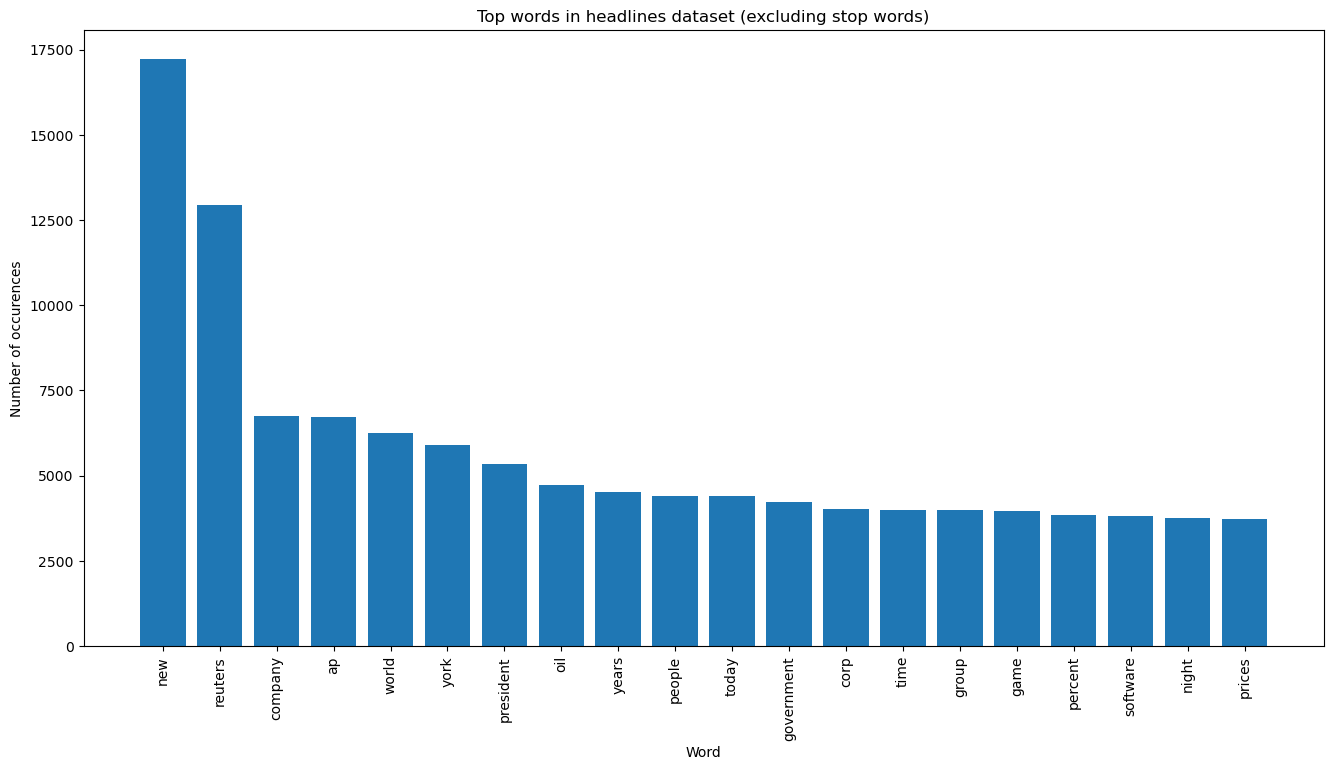

In [14]:
import numpy as np

def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    Returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample

    Parameters:
        n_top_words (int): Number of top words to return.
        count_vectorizer (CountVectorizer): CountVectorizer object.
        text_data (pandas Series): The text data to be vectorized.

    Returns:
        tuple: A tuple containing two lists, one with the top n words and another with their corresponding counts.
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0, :], 1)
    word_values = np.flip(np.sort(vectorized_total)[0, :], 1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i, word_indices[0, i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0, :n_top_words].tolist()[0])

# Example usage:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object
count_vectorizer = CountVectorizer(stop_words='english')

# Get the top n words and their counts from the 'Description' column
top_words, word_counts = get_top_n_words(20, count_vectorizer, df1['filtered_description'])

print("Top Words:", top_words)
print("Word Counts:", word_counts)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(top_words)), word_counts);
ax.set_xticks(range(len(top_words)));
ax.set_xticklabels(top_words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

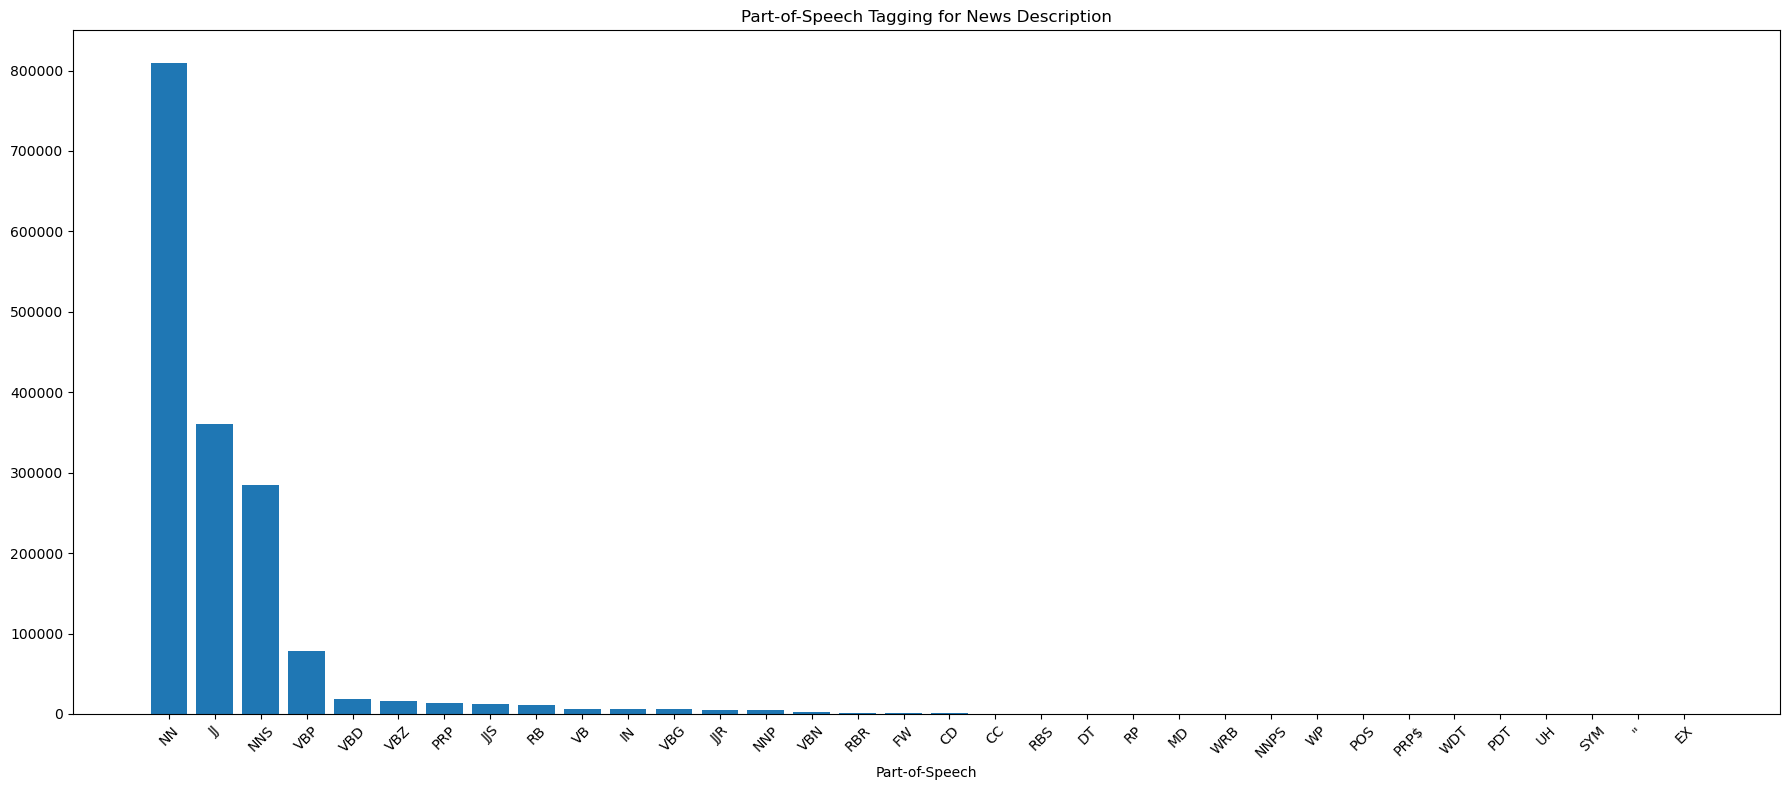

In [15]:
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from collections import defaultdict

pos_counts = defaultdict(int)
for description in df1['filtered_description']:
    tokens = word_tokenize(description)
    tagged_tokens = pos_tag(tokens)
    for word, pos in tagged_tokens:
        pos_counts[pos] += 1

# Sort the part-of-speech tags and their counts
pos_sorted_types = sorted(pos_counts, key=pos_counts.get, reverse=True)
pos_sorted_counts = [pos_counts[pos] for pos in pos_sorted_types]

# Create the bar plot
fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(range(len(pos_counts)), pos_sorted_counts)
ax.set_xticks(range(len(pos_counts)))
ax.set_xticklabels(pos_sorted_types)
ax.set_title('Part-of-Speech Tagging for News Description')
ax.set_xlabel('Part-of-Speech')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Total number of words: 1640419
Mean number of words per headline: 13.670158333333333


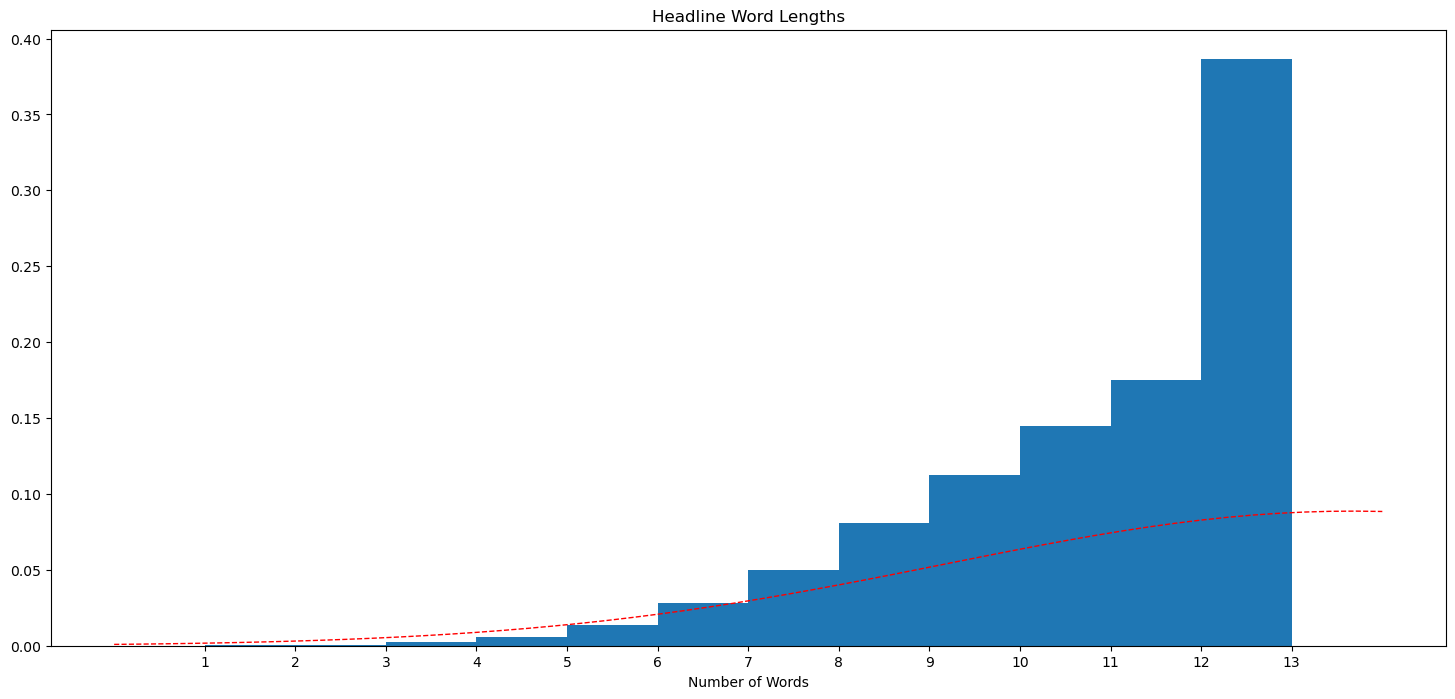

In [16]:
tagged_headlines = [pos_tag(word_tokenize(desc)) for desc in df1['filtered_description']]

# Create DataFrame to store the tagged headlines
tagged_headlines_df = pd.DataFrame({'tags': tagged_headlines})

# Calculate word lengths and part-of-speech counts
word_counts = []
pos_counts = {}

for headline in tagged_headlines_df['tags']:
    word_counts.append(len(headline))
    for word, pos in headline:
        if pos in pos_counts:
            pos_counts[pos] += 1
        else:
            pos_counts[pos] = 1

print('Total number of words:', np.sum(word_counts))
print('Mean number of words per headline:', np.mean(word_counts))

# Plot word lengths
y = stats.norm.pdf(np.linspace(0, 14, 50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18, 8))
ax.hist(word_counts, bins=range(1, 14), density=True)
ax.plot(np.linspace(0, 14, 50), y, 'r--', linewidth=1)
ax.set_title('Headline Word Lengths')
ax.set_xticks(range(1, 14))
ax.set_xlabel('Number of Words')
plt.show()

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Initialize CountVectorizer
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,  # minimum required occurrences of a word 
                             stop_words='english',  # remove stop words
                             lowercase=True,  # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=5000,  # max number of unique words
                            )

data_vectorized = vectorizer.fit_transform(df1['filtered_description'])

# Initialize LDA Model with 4 topics
lda_model = LatentDirichletAllocation(n_components=4, random_state=42)

# Fit the model to the data
lda_model.fit(data_vectorized)

# Transform the data
data_lda = lda_model.transform(data_vectorized)

# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Visualizing the models with pyLDAvis



Topic 0:


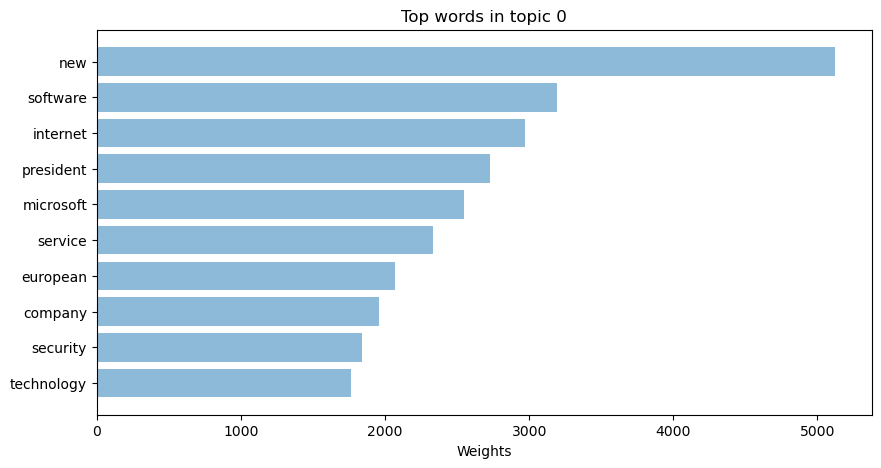

Topic 1:


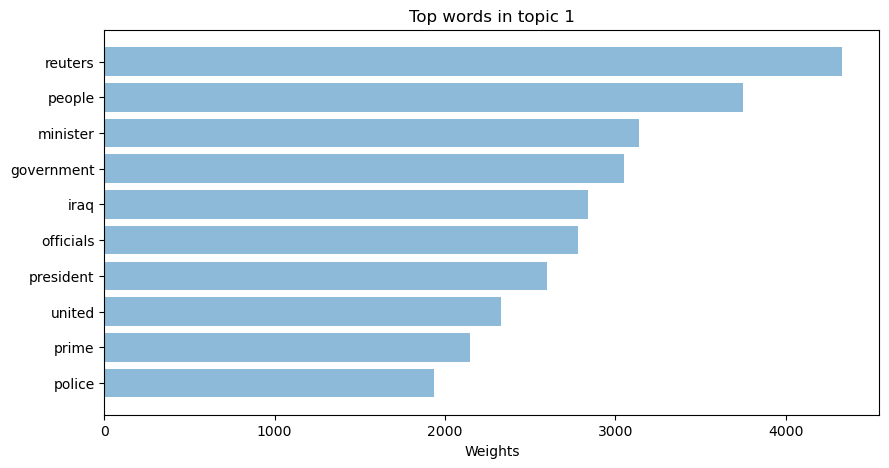

Topic 2:


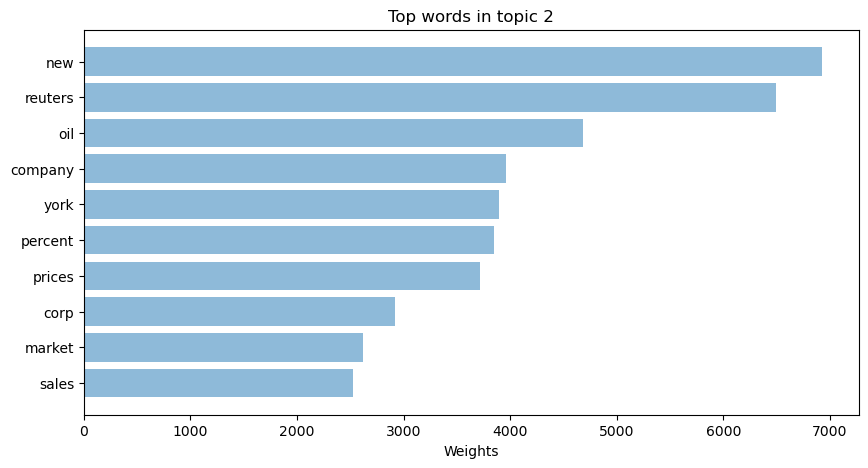

Topic 3:


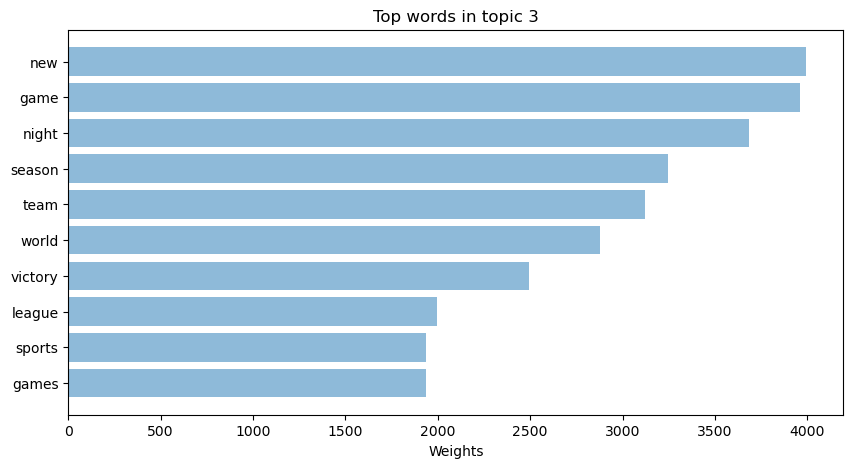

In [18]:
import matplotlib.pyplot as plt

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        top_words_weights = sorted(topic)[:-no_top_words - 1:-1]
        
        plt.figure(figsize=(10,5))
        plt.barh(range(no_top_words), top_words_weights, align='center', alpha=0.5)
        plt.yticks(range(no_top_words), top_words)
        plt.xlabel('Weights')
        plt.title(f'Top words in topic {topic_idx}')
        plt.gca().invert_yaxis()
        plt.show()

no_top_words = 10
display_topics(lda_model, feature_names, no_top_words)


In [19]:
df2 = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv')
df2.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [20]:
print(feature_names)

['aaron' 'abbas' 'abbey' ... 'zone' 'zook' 'zurich']


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Let's assume df1['Class Index'] are the labels for your documents
labels = df1['Class Index']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_lda, labels, test_size=0.2, random_state=42)

# Initialize the classifier
clf = LogisticRegression(random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.68      0.70      5911
           1       0.68      0.66      0.67      6075
           2       0.89      0.92      0.91      6058
           3       0.73      0.77      0.75      5956

    accuracy                           0.76     24000
   macro avg       0.75      0.76      0.76     24000
weighted avg       0.76      0.76      0.76     24000

[[4001  966  119  825]
 [1151 3984  281  659]
 [  53  212 5597  196]
 [ 358  690  313 4595]]
